# Causal Interpretation for Boston Housing Price

This notebook uses the well-known Boston Housing dataset to showcase how we can interpret a blackbox model from both the **correlation and causation** perspective by leveraging the power of model interpretation tools like [SHAP](https://shap.readthedocs.io/en/latest/index.html) and [EconML](https://aka.ms/econml). This housing dataset collects median home values and neighborhood characteristics for the Boston area, largely from the 1970 U.S. Census. We start with a linear regression to build intuition. We then train a fine-tuned predictive ML model and use SHAP to better understand the correlations between features and target and which features are the strongest predictors. Finally, we train a separate causal model using EconML, which identifies features that have a **direct causal effect** on housing price, instead of just predicting the housing price given a set of characteristics.

Also, this dataset has attracted some controversy because it includes the **share of Black residents (`B`)** in the neighborhood as a possible predictor of home prices. In addition to the fairness implications of using neighborhood racial mix to predict prices, our analysis shows that the statistical relationship between the share of Black residents and home prices is **not a causal effect**. In the 1970s in Boston, Black residents were concentrated in less desirable neighborhoods—for example those with higher pollution, higher crime, and smaller houses. This pattern of correlations makes the share of Black residents an effective predictive feature, as shown in our SHAP analysis, but we find that it has no direct causal effect on home prices. In other words, in this historical dataset neighborhoods with higher shares of Black residents also tend to have lower median home prices, but we show that changing the racial mix of a neighborhood on its own would not change median home prices.

It includes the following sections:
1. [A Gentle Start: Linear Regression](#A-Gentle-Start:-Linear-Regression)
2. [Train a Fine-tuned Predictive ML Model](#Train-a-Fine-tuned-Predictive-ML-Model)
3. [Correlation Interpretation](#Correlation-Interpretation)
    * Feature Importance -- Learn the top predictors for a given ML model
    * Partial Dependence Plot -- Learn the statistical relationship between share of Black residents and housing price
4. [Causal Interpretation](#Causal-Interpretation)
    * Direct Causal Effect -- Do the top predictors also have a direct effect on outcome of interest?
    * Segmentation -- How different type of houses respond differently to number of rooms?
    * What If Analysis -- How the overall housing price changes with one more room?
    * Policy Analysis -- What is the best policy considering cost?
    * Cohort Analysis -- What is the causal effect on a new dataset?
    

In [1]:
# Some imports to get us started
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

# A Gentle Start: Linear Regression

### Data Description

The data contain features of Boston census tracts in 1970 and was originally published by Harrison, D. and Rubinfeld, D.L. [Hedonic prices and the demand for clean air](https://www.law.berkeley.edu/files/Hedonic.PDF), J. Environ. Economics & Management, vol.5, 81-102, 1978.

Below is a list of data description:

Feature Name|Description
:--- |:---
**CRIM**|per capita crime rate by town
**ZN**|proportion of residential land zoned for lots over 25,000 sq.ft.
**INDUS**|proportion of non-retail business acres per town.
**CHAS**|Charles River dummy variable (1 if tract bounds river; 0 otherwise)
**NOX**|nitric oxides concentration (parts per 10 million)
**RM**|average number of rooms per dwelling
**AGE**|proportion of owner-occupied units built prior to 1940
**DIS**|weighted distances to five Boston employment centres
**RAD**|index of accessibility to radial highways
**TAX**|full-value property-tax rate per \$10,000
**PTRATIO**|pupil-teacher ratio by town
**B**|$1000\dot(Bk - 0.63)^2$ where Bk is the proportion of Black residents by town
**LSTAT**|\% lower socioeconomic status by town: $\frac{1}{2}$(share of adults with less than high school education + share of male workers classified as laborers)
**MEDV**|Median value of owner-occupied homes in \$1000's

We start with a linear regression to learn the correlation between each predictor and the outcome variable, the coefficients could tell us how the housing price will change with one unit increase of each feature, and the p-value tells us the variable significance.

In [2]:
# Load the boston housing data
from sklearn.datasets import load_boston

boston_data = load_boston()

In [3]:
# Train a linear regression using statsmodels
X = sm.add_constant(boston_data.data)
X_df = pd.DataFrame(X, columns=["Intercept"] + boston_data.feature_names.tolist())
model = sm.OLS(boston_data.target, X_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 20 Jul 2021   Prob (F-statistic):          6.72e-135
Time:                        17:58:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
CRIM          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
ZN             0.0464      0.014      3.382      0.001       0.019       0.073
INDUS          0.0206      0.061      0.334      0.738      -0.100       0.141
CHAS           2.6867      0.862      3.118      0.002       0.994       4.380
NOX          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
RM             3.8099      0.418      9.116      0.000       2.989       4.631
AGE            0.0007      0.013      0.052      0.958      -0.025       0.027
DIS           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
RAD            0.3060      0.066      4.613      0.000       0.176       0.436
TAX           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
PTRATIO       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
B              0.0093      0.003      3.467      0.001       0.004       0.015
LSTAT         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Train a Fine-tuned Predictive ML Model

Now we train a LightGBM regression model and use grid search to do model tuning.

In [4]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    boston_data.data, boston_data.target, test_size=0.2, random_state=0
)

In [5]:
categorical = ["CHAS"]
# Store the numerical columns in a list numerical
numerical = list(set(boston_data.feature_names).difference(set(categorical)))

In [6]:
# train a lightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)

In [7]:
search.fit(x_train, y_train)
print("Best estimator: ", search.best_params_)

Best estimator:  {'learning_rate': 0.1, 'max_depth': 10}


In [8]:
print("Test set score: ", search.best_estimator_.score(x_test, y_test))

Test set score:  0.7025992540638362


# Correlation Interpretation
### Feature Importance - Shap Value
We explain this ML model by understanding the top important features to predict the housing price, internally using **shap value**.

In [9]:
fitted_model = search.best_estimator_

In [10]:
import shap

# use interventional approach
background = shap.maskers.Independent(x_train, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=boston_data.feature_names
)
shap_values = explainer(x_test)

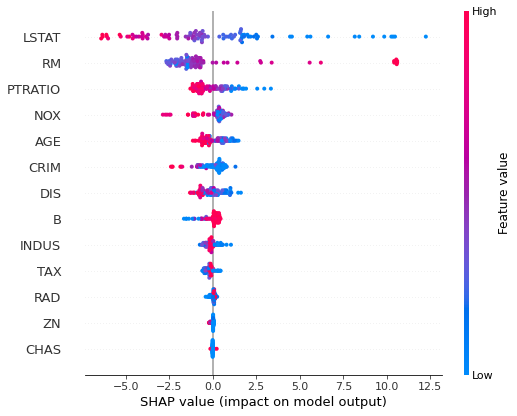

In [11]:
# plot the feature importance
shap.summary_plot(shap_values, x_test)

From the summary plot above, we could see the **most important features** sorted by their importance level. It tells us that neighborhoods with a smaller shares of low socioeconomic status residents, higher median number of rooms and less pupil-teacher ratio will have a higher housing price. It's also in line with what we learnt from Linear Regression above.

### Partial Dependence Plot -- Statistical relationship between share of Black residents and housing price

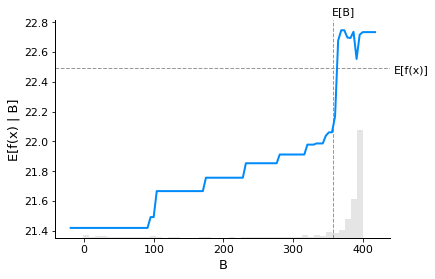

In [12]:
shap.plots.partial_dependence(
    "B",
    fitted_model.predict,
    pd.DataFrame(boston_data.data, columns=boston_data.feature_names),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Taking share of Black residents as an example, here `B` is a function of Black population in town, the higher of `B`, the lower of Black population(%). From the coefficient of linear regression, the shap summary plot and also the partial dependence plot, we could get the same conclusion that there is a positive correlation between `B` and median housing price. In other word, housing price will decrease with the increasing of Black population(%). However, is that really **causal**? Let us validate that in the following section. 

Overall, all the insights above are coming from **corelation** perspective, telling us the positive or negative correlation between each predictor and the target. In order to correctly find the **casusal** relationship, we have to train a different model controlling on all the possible **hidden variables (confounders)** and learn the **direct causal effect** for a given feature. That's what the causal interpretation tool is doing. In the following section, we will explore the causal relationship in different ways.

# Causal Interpretation
### Direct Causal Effect --  Do the top predictors also have a direct effect on outcome of interest?

In [13]:
classification = False
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns=["features", "importance"]
)
feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
top_features = feature_importance["features"]

In [14]:
from econml.solutions.causal_analysis import CausalAnalysis

ca = CausalAnalysis(
    top_features,
    categorical,
    heterogeneity_inds=None,
    classification=classification,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
)
ca.fit(pd.DataFrame(x_train, columns=boston_data.feature_names), y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [15]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
RM,num,4.495641,0.399317,11.258321,2.107348e-29,3.712994,5.278288
LSTAT,num,-0.450849,0.083196,-5.419148,5.988376e-08,-0.613909,-0.287789
PTRATIO,num,-1.834813,0.441934,-4.151783,3.298943e-05,-2.700987,-0.968639
CHAS,1.0v0.0,5.555234,1.465717,3.790114,1.505781e-04,2.682482,8.427986
CRIM,num,-0.879386,0.325632,-2.700552,6.922443e-03,-1.517613,-0.241159
INDUS,num,-0.456560,0.213477,-2.138692,3.246064e-02,-0.874967,-0.038154
AGE,num,-0.028304,0.020342,-1.391440,1.640919e-01,-0.068173,0.011565
NOX,num,-8.422913,6.143376,-1.371056,1.703575e-01,-20.463710,3.617883
B,num,-0.005655,0.005880,-0.961728,3.361862e-01,-0.017180,0.005870


In [16]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

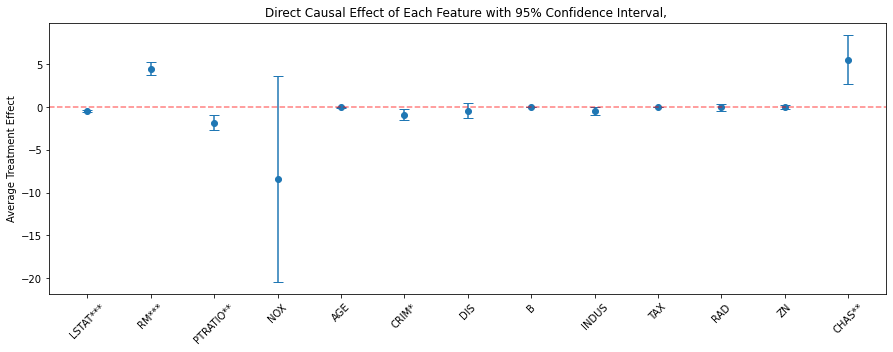

In [17]:
errorbar(global_summ)

We learn the **Average Treatment Effect (ATE)** for each feature, assuming they are the treatment. The error bar above is ordered by **feature importance**, and the summary table above is ordered by **causal significance (p-value)**. You could see they are not exact in the same order. Some top features such as percentage of lower status population (`LSTAT`) and number of rooms (`RM`), they are the strongest predictors and also have a direct causal effect on housing price, but others like pupil-teacher ratio (`PTRATIO`) and nitric oxides concentration (`NOX`) they don't really have significant causal effect on housing price. Also on the other side features like whether in Charles River Area (`CHAS`), it doesn't have strong prediction power comparing with others features, but it has a direct causal effect. 

Following on the findings we learnt for share of Black residents (`B`), we could see it also gives us insignificant causal effect on housing price, which means race by itself has no direct causal effect on home prices. By learning the correlation between `B` and other features, we could see it's highly correlated with crime rate(`CRIM`) and percentage of lower status population (`LSTAT`), which do have strong causal effects. This pattern of correlations make `B` as a strong predictor but not a direct driver. Using the causal analysis tool has helped us **avoid reaching a controversial and incorrect conclusion**. 

To sum up, EconML could give us some extra insights from **causal relationship** perspective.

### Segmentation -- How different type of houses respond differently to number of rooms?
From the analysis above, we learnt the direct treatment effect of each feature from an overall average level. However, different regions might respond differently on housing price for each potential driver. In the following section, we are going to use number of rooms (`RM`) as an example to learn how different type of houses respond differently to number of rooms? 

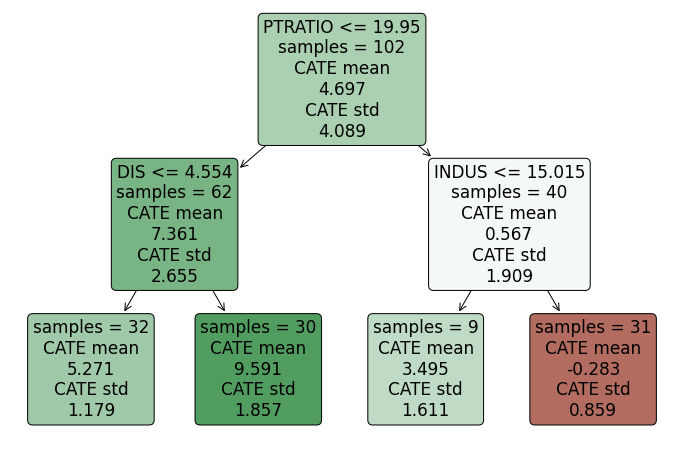

In [18]:
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    max_depth=2,
    min_impurity_decrease=1e-6,
)

From the global level, we know that the ATE of `RM` is 4.5, which means in average adding one more room will raise the housing price by 4.5 unit. In the shallow tree above, we could see although overall `RM` has a significant positive effect on housing price, but housing price will be more expensive for one more room in regions with lower pupil-teather rate, and the effect will be insignificant in the regions with higher pupil-teather rate and lower retail business rate. 

### Policy Analysis -- What is the best policy considering cost?
To take a step further, we'd like to know the sub-population where the treatment effect will still be positive after taking cost into consideration. Assuming the average cost of adding one more room is 4 units, let us see what kind of houses their housing price will increase more than their cost.  

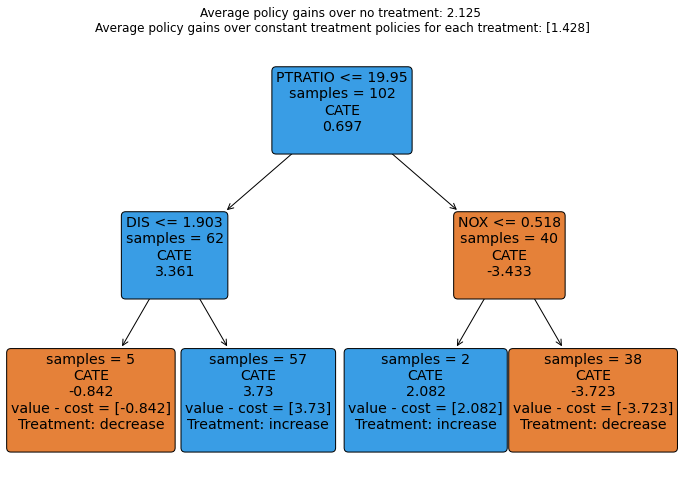

In [19]:
plt.figure(figsize=(12, 8))
ca.plot_policy_tree(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    treatment_costs=4,
    max_depth=2,
)

You could see if we follow the recommended policy above, in average, the housing price will increase by 2 more units comparing with no more room added. Similarly, it will increase by around 1.4 units comparing with adding one more room for every house. To be more detailed, we could also output the individualized policy. In the following table, I will only print the top five houses ordered by policy gains.

In [20]:
ca.individualized_policy(
    pd.DataFrame(x_test, columns=boston_data.feature_names),
    "RM",
    n_rows=5,
    treatment_costs=4,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,CRIM,ZN,INDUS,CHAS,NOX,Current treatment,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
35,decrease,5.193029,4.105445,6.280613,4.22239,0.0,18.10,1.0,0.770,5.803,89.0,1.9047,24.0,666.0,20.2,353.04,14.64
37,decrease,4.971283,3.978139,5.964427,8.26725,0.0,18.10,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88
17,increase,4.903631,3.106725,6.700537,0.04011,80.0,1.52,0.0,0.404,7.287,34.1,7.3090,2.0,329.0,12.6,396.90,4.08
12,decrease,4.829410,4.165281,5.493539,6.28807,0.0,18.10,0.0,0.740,6.341,96.4,2.0720,24.0,666.0,20.2,318.01,17.79
91,decrease,4.728159,3.751451,5.704868,11.16040,0.0,18.10,0.0,0.740,6.629,94.6,2.1247,24.0,666.0,20.2,109.85,23.27


Note that here the `effect of treatment` is the treatment effect of increasing or decreasing 10% of average treatment level minus the cost, and `decrease` or `increase` mean in which direction we will get positive policy gain.

### What If Analysis - How the overall housing price changes with one more room?
The causal analysis tool could also answer **what if** types of questions. For a given treatment, we'd also like to know the **counterfactuals** if we intervene it in a different way. In the example below, we will learn how the overall housing price changes with one more room?

In [21]:
cf = ca.whatif(x_test, x_test[:, 5] + 1, 5, y_test)
print("Current average housing price on test set: ", y_test.mean())
print(
    "Average housing price with one more room on test set: ",
    cf["point_estimate"].mean(),
)

Current average housing price on test set:  22.21960784313725
Average housing price with one more room on test set:  26.916421568627456


Text(0.5, 1.0, 'Histogram of Housing price -- Current vs. One more room')

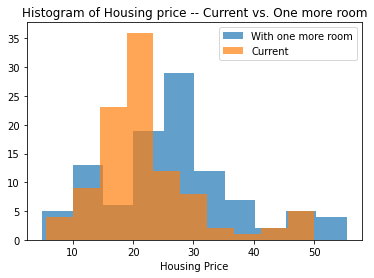

In [22]:
# distribution comparison
plt.hist(cf.point_estimate, label="With one more room", alpha=0.7)
plt.hist(y_test, label="Current", alpha=0.7)
plt.legend()
plt.xlabel("Housing Price")
plt.title("Histogram of Housing price -- Current vs. One more room")

From the summary table we could see overall if we add one more room in the test set, the housing price will increase by 4+ units, which is in line with the ATE we learnt above. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we add one more room.

### Cohort Analysis -- What is the causal effect on a new dataset?
Causal analysis class could also help us to learn the global and local causal effect of a new dataset given the model trained with training set. From the two tables below, you could see the global effect on test set is similar with training set, and the local effect gives you the heterogeneous treatment effect for each observation.

In [23]:
# global effect on new dataset
ca.cohort_causal_effect(x_test)

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
LSTAT,num,-0.403059,0.078745,-5.118549,3.078958e-07,-0.532583,-0.273536
RM,num,4.696792,0.480445,9.775918,1.428563e-22,3.906530,5.487054
PTRATIO,num,-2.064864,0.546016,-3.781692,1.557659e-04,-2.962980,-1.166748
NOX,num,-5.111412,6.638709,-0.769941,4.413351e-01,-16.031116,5.808292
AGE,num,-0.019404,0.018952,-1.023836,3.059127e-01,-0.050577,0.011770
CRIM,num,-0.751323,0.311513,-2.411851,1.587175e-02,-1.263716,-0.238930
DIS,num,-0.417847,0.438805,-0.952238,3.409765e-01,-1.139617,0.303923
B,num,0.000873,0.005519,0.158228,8.742774e-01,-0.008205,0.009952
INDUS,num,-0.546875,0.307997,-1.775585,7.580141e-02,-1.053485,-0.040265


In [24]:
# local effect on new dataset
ca.local_causal_effect(x_test)

point     stderr     zstat   p_value  \
sample feature feature_value                                             
0      LSTAT   num            -0.086647   0.198795 -0.435862  0.662937   
       RM      num             9.387421   2.121412  4.425081  0.000010   
       PTRATIO num             0.610745   0.651034  0.938116  0.348185   
       NOX     num            25.792624  32.291454  0.798745  0.424439   
       AGE     num            -0.063210   0.047780 -1.322930  0.185859   
...                                 ...        ...       ...       ...   
101    INDUS   num            -0.595808   0.252946 -2.355475  0.018499   
       TAX     num            -0.016860   0.013712 -1.229612  0.218842   
       RAD     num             0.102697   0.492187  0.208655  0.834718   
       ZN      num            -0.159129   0.091308 -1.742776  0.081373   
       CHAS    1.0v0.0         8.870247   4.602972  1.927070  0.053971   

                               ci_lower   ci_upper  
sample feature feature_value                        
0      LSTAT   num            -0.413635   0.240341  
       RM      num             5.898009  12.876833  
       PTRATIO num            -0.460110   1.681600  
       NOX     num           -27.322091  78.907338  
       AGE     num            -0.141802   0.015382  
...                                 ...        ...  
101    INDUS   num            -1.011868  -0.179749  
       TAX     num            -0.039414   0.005694  
       RAD     num            -0.706878   0.912272  
       ZN      num            -0.309316  -0.008941  
       CHAS    1.0v0.0         1.299032  16.441462  

[1326 rows x 6 columns]